<center>
    <h1> INF510 - Advanced Computational Methods  </h1>
    <h2> Homework #3 - Spectral Methods  </h2> 
</center>

* Martín Villanueva - `martin.villanueva@alumnos.usm.cl` - **rol:** 201104012-0

_DI UTFSM. December 2016._

In [1]:
#%matplotlib notebook
%matplotlib inline 

import numpy as np
from scipy.linalg import toeplitz
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed

### Helper functions

In [2]:
def cheb(N):
    if N==0:
        D=0.
        x=1.
        return D,x
    x = np.cos(np.pi*np.arange(N+1)/N)
    c=np.hstack((2,np.ones(N-1),2))*((-1.)**np.arange(N+1))
    X=np.tile(x,(N+1,1)).T
    dX=X-X.T
    D = np.outer(c,1./c)/(dX+np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    return D,x

def plot_helper(x, t, u, index):
    plt.plot(x, u[index], 'ro-')
    plt.title('Plot of $u(x,t)$ at t={0}'.format(t[index]))
    plt.xlabel('$x$')
    plt.ylabel('$u(x,t)$')
    plt.show()
    
def _plot_helper(x, t, u, index):
    plt.axes([.1,.1,.8,.7])
    plt.title('Plot of $u(x,t)$ at t={0}'.format(t[index]))
    plt.text(1.1, 1.1, '$u(0,t)=${0}'.format(u[index, len(x)/2]))
    plt.xlabel('$x$')
    plt.ylabel('$u(x,t)$')
    plt.plot(x, u[index], 'ro-')
    plt.show()

def plot_helper2(xx, yy, V, t, index):  
    fig = plt.figure(figsize=(13,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, V[index], linewidth=0.0, cmap='jet')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('v')
    plt.title('Solution of $u(x,y,t)$ at t={0}'.format(t[index]))
    plt.show()

## Part 1

### `Program 27`


The problem consists in solving the KdV equation (_Korteweg–de Vries_), which takes the form:
$$ u_t = u u_x + u_{xxx}, $$
in the $[-\pi,\pi]$ domain. This equation corresponds to a mathematical model of waves on shallow water surfaces, known because it is an exactly solvable model!.


The initial conditions are solitary waves of the form:
$$ u(x,t) = 3 a^2 \text{sech}^2\left(\frac{a(x-x_0)}{2}-a^3 t\right). $$


We are not interested in the boundary conditions since the solutions decay exponentially (the implicit assumption is that $u(\cdot,t)=0$ at the boundary).


Since the nonlinearity term causes trouble in an explicit time-stepping method (it would work but with very small time steps for stable solutions), some arrangements are done.  


These arrangements are based on the _method of integrating factors_, and work by suppressing the influence of the term $u_{xxx}$ which is the one involving high frequencies.
\begin{align}
u_t + \left(\frac{1}{2} u^2 \right)_x + u_{xxx} &= 0 \ \ \ \ \ \ \ / \mathcal{F}() \\
\hat{u_t} + \frac{i}{2} k \hat{u^2} - i k^3 \hat{u} &= 0 \ \ \ \ \ \ \ / \cdot e^{-ik^3 t} \\
e^{-ik^3 t} \hat{u_t} + \frac{i}{2} e^{-ik^3 t} k \hat{u^2} - i e^{-ik^3 t} k^3 \hat{u} &= 0 \ \ \ \ \ \ \ \text{if } \hat{U} = e^{-ik^3 t} \hat{u} \ \text{with } \hat{U}_t = -ik^3 \hat{U} + e^{-ik^3 t} \hat{u}_t \\
\hat{U}_t + \frac{i}{2} e^{-i k^3 t} k \mathcal{F}((\mathcal{F}^{-1}(e^{ik^3 t} \hat{U}))^2) &= 0
\end{align}
The last equation is much more simpler and the influence of the linear term is gone. Now we perform the finite-difference step on the _Fourier space_. Then the algorithm works as follows:
1. Map the initial conditions to the fourier space with the corresponding factor: $\hat{U}_0 = e^{-ik^3 t} \hat{u}_0$.
2. Run a simple ODE solver over $\hat{U}_t + \frac{i}{2}e^{-ik^3t}k \hat{u^2} = 0$ as usual (RK4 is used here, for stability reasons).
3. The get the solution in the original space compute: $u(x,t) = \mathcal{F}^{-1}(e^{ik^3 t} \hat{U})$.

In [5]:
# number of grid points
N = 256

# time step
dt = .4/N**2

# x-grid
xgrid = (2*np.pi/N) * np.linspace(-N/2, N/2-1, N)

# some problem constants
A = 25.; B = 16.

# initial conditions
u0 = (3*A**2) * np.cosh(.5*A*(xgrid+2))**(-2) + (3*B**2) * np.cosh(.5*B*(xgrid+1))**(-2)
v = np.fft.fft(u0)

# wave numbers
k = np.concatenate((np.arange(0,N/2), np.array([0]), np.arange(-N/2+1,0,1)))

ik3 = 1j*k**3
E = np.exp(dt*ik3/2); E2 = E**2
g = -.5j*dt*k


# ode solver parameters
tmax = 0.006
n_iter = int(round(tmax/dt))
time_grid = np.linspace(0., tmax, n_iter+1)

# solution array
U = np.empty((n_iter+1, len(u0)))
U[0] = u0

In [6]:
for i in range(1, n_iter+1):
    # RK4 method
    k1 = g * np.fft.fft( np.real( np.fft.ifft( v ) )**2 )
    k2 = g * np.fft.fft( np.real( np.fft.ifft( E*(v + k1/2) ) )**2 )
    k3 = g * np.fft.fft( np.real( np.fft.ifft( E*v + k2/2 ) )**2 )
    k4 = g * np.fft.fft( np.real( np.fft.ifft( E2*v + E*k3 ) )**2 )
    v = E2*v + (E2*k1 + 2*E*(k2+k3) + k4)/6
    # we just store the solution at the original domain
    U[i] = np.real( np.fft.ifft(v) )

<IPython.core.display.Javascript object>


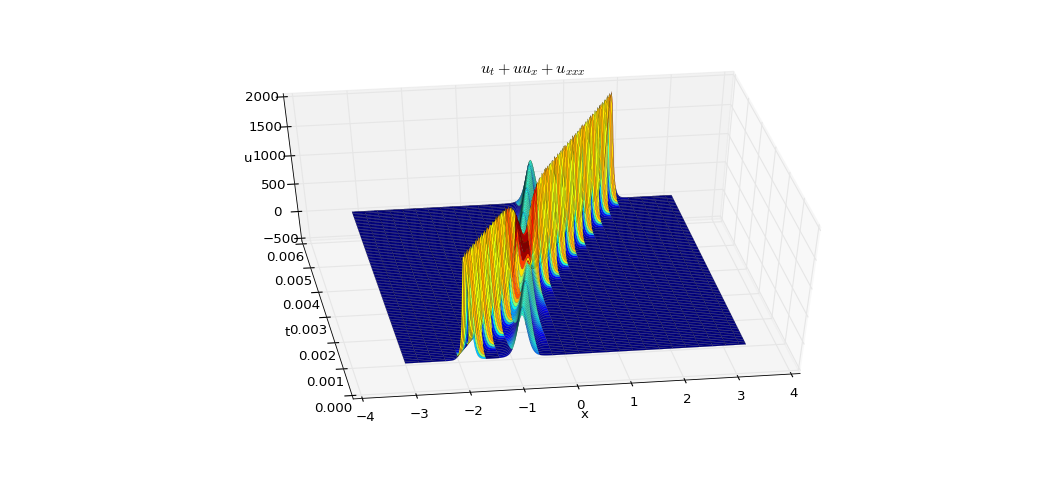

In [7]:
X , T = np.meshgrid(xgrid, time_grid, sparse=True)
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U, linewidth=0.1, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('$u_t + u u_x + u_{xxx}$')
plt.show()

### `Program 34`

In [24]:
# number of grid points
N = 20

# differentiation matrix and initial data
D,x = cheb(N); D2 = np.dot(D,D)
D2[[0, -1]] = 0.

# parameter of the PDE
eps = 0.01

# time step
dt = min(0.01, 50/(eps*N**4)) 

# initial conditions
u0 = 0.53*x + 0.47*np.sin(-1.5*np.pi*x)

# ode solver parameters
tmax = 100
n_iter = int(round(tmax/dt))
t= np.linspace(0., tmax, n_iter+1)

# solution array
U = np.empty((n_iter+1, len(u0)))
U[0] = u0

# Euler method
for i in range(1, n_iter+1):
    U[i] = U[i-1] + dt * (eps*np.dot(D2, U[i-1]) + U[i-1] - U[i-1]**3)

__note:__ Fix the colormap visualization.

<IPython.core.display.Javascript object>


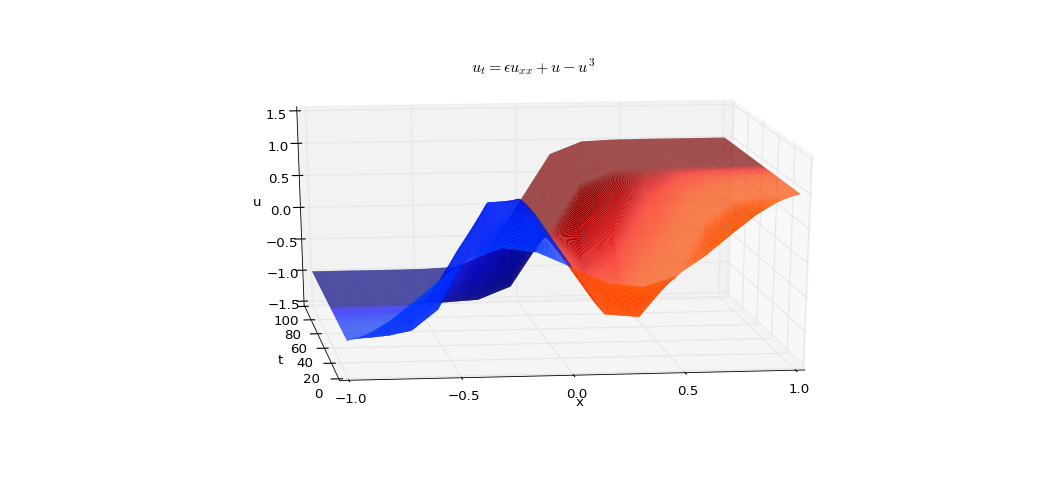

In [25]:
X,T = np.meshgrid(x, t, sparse=True)
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U, linewidth=0.0, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('$u_t = \epsilon u_{xx} + u - u^3$')
plt.show()

### `Program 35`

In [26]:
# number of grid points
N = 20

# differentiation matrix and initial data
D,x = cheb(N); D2 = np.dot(D,D)

# parameter of the PDE
eps = 0.01

# time step
dt = min(0.01, 50/(eps*N**4)) 

# initial conditions
u0 = 0.53*x + 0.47*np.sin(-1.5*np.pi*x)

# ode solver parameters
tmax = 100
n_iter = int(round(tmax/dt))
t = np.linspace(0., tmax, n_iter+1)

# solution array
U = np.empty((n_iter+1, len(u0)))
U[0] = u0

# Euler method
for i in range(1, n_iter+1):
    U[i] = U[i-1] + dt * (eps*np.dot(D2, U[i-1]) + U[i-1] - U[i-1]**3)
    U[i, 0] = 1 + np.sin(t[i]/5)**2; U[i, -1] = -1

<IPython.core.display.Javascript object>


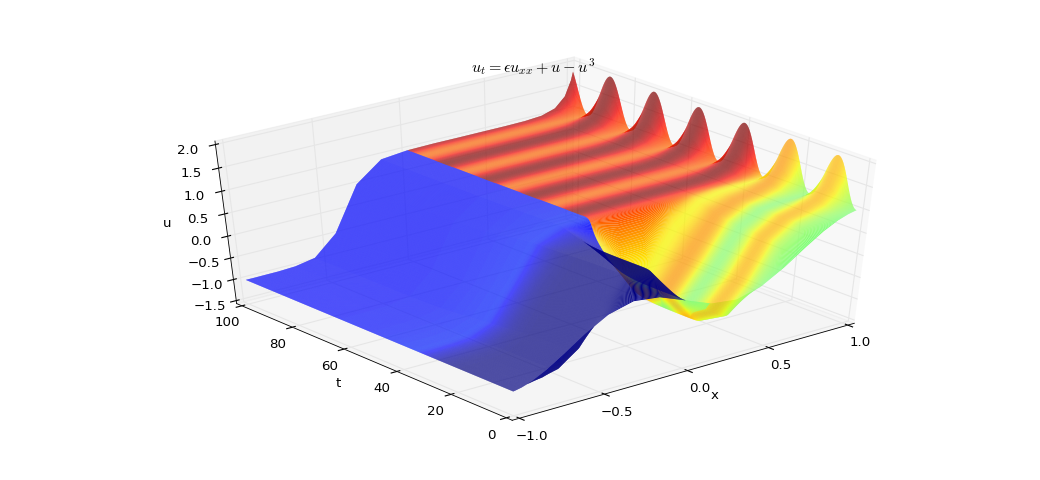

In [27]:
X,T = np.meshgrid(x, t, sparse=True)
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U, linewidth=0.0, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('$u_t = \epsilon u_{xx} + u - u^3$')
plt.show()

### `Program 37`

In [5]:
# x variable in [A,-A], Fourier
A = 3.; Nx = 100; dx = 2.*A/Nx; x = np.arange(-A+dx, A+dx, dx)
row = np.concatenate(([-1/(3*(dx/A)**2)-1/6], (.5*(-1)**np.arange(2,Nx+1)) / np.sin((np.pi*dx/A) * np.arange(1,Nx)/2)**2))
D2x = (np.pi/A)**2 * toeplitz(row)

# y variable in [-1, 1], Chebyshev
Ny = 30; Dy,y = cheb(Ny); D2y = np.dot(Dy, Dy)
BC = np.linalg.solve(-Dy[[0,0,-1,-1],[0,-1,0,-1]].reshape((2,2)), Dy[[0,-1],1:Ny])


# ode solver parameters
dt = 5./(Nx+Ny**2)
tmax = 5
n_iter = int(round(tmax/dt))
t = np.linspace(0., tmax, n_iter+1)

# grid an initial data
xx,yy = np.meshgrid(x, y)
vv = np.exp(-8.*((xx+1.5)**2 + yy**2))
vvold = np.exp(-8.*((xx+dt+1.5)**2 + yy**2))

# solution array
V = np.empty((n_iter+1, vv.shape[0], vv.shape[1]))
V[0] = vv

# Leap-Frog method
for i in range(1, n_iter+1):
    vvnew = 2*vv - vvold + (dt**2)*(np.dot(vv,D2x) + np.dot(D2y,vv))
    vvold = vv; vv = vvnew
    vv[[0,-1]] = np.dot(BC, vv[1:Ny])
    V[i] = vv

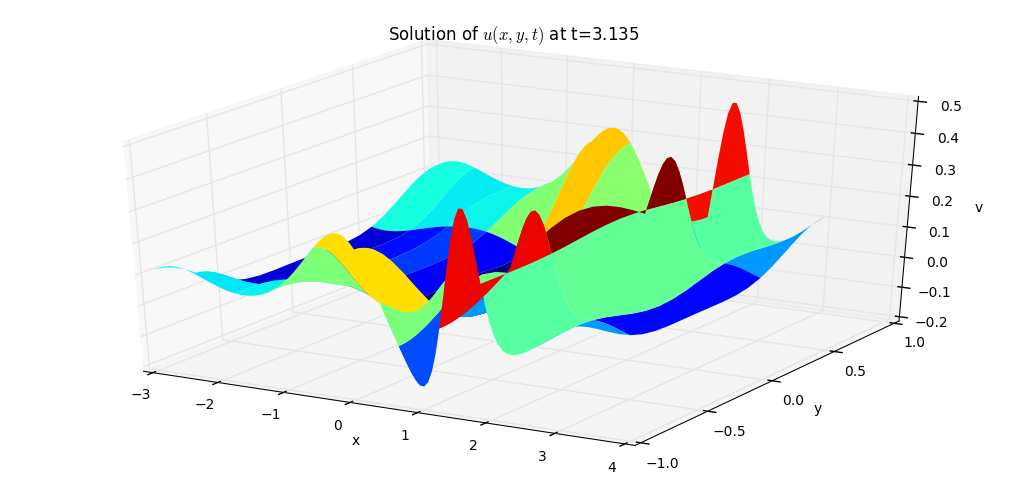

In [6]:
interact(plot_helper2, xx=fixed(xx), yy=fixed(yy), V=fixed(V), t=fixed(t), index=(0,len(t)))

***
***
## Part 2

__Note:__ This corresponds to exercise 10.4 from _Spectral Methods in Matlab, Trefethen._

In [78]:
# number of grid points
N = 30

# differentiation matrix and initial data
D,x = cheb(N); D2 = np.dot(D,D)

# initial condition
u0 = np.zeros(x.shape[0])

# ode solver parameters
dt = 0.00001
tmax = 3.6
n_iter = int(round(tmax/dt))
t = np.linspace(0., tmax, n_iter+1)

# solution array
U = np.empty((n_iter+1, len(u0)))
U[0] = u0

def Ut(u):
    """
    It takes the values of u(x,t) at a given time t,
    and computes the temporal derivatives
    """
    return np.dot(D2, u) + np.exp(u)

# Ode solver to use
method = 'rk4'

if method=='euler':
    # Euler method
    for i in range(1, n_iter+1):
        U[i] = U[i-1] + dt * Ut(U[i-1])
        # enforcing boundary conditions
        U[i,0] = U[i,-1] = 0

elif method=='rk4':
    # RK4 method
    for i in range(1, n_iter+1):
        k1 = Ut( U[i-1] )
        k2 = Ut( U[i-1] + (dt/2.)*k1 )
        k3 = Ut( U[i-1] + (dt/2.)*k2 )
        k4 = Ut( U[i-1] + dt*k3)
        U[i] = U[i-1] + (dt/6.)*(k1 + 2*k2 + 2*k3 + k4)
        # enforcing boundary conditions
        U[i,0] = U[i,-1] = 0

/home/martin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: overflow encountered in exp
/home/martin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in add


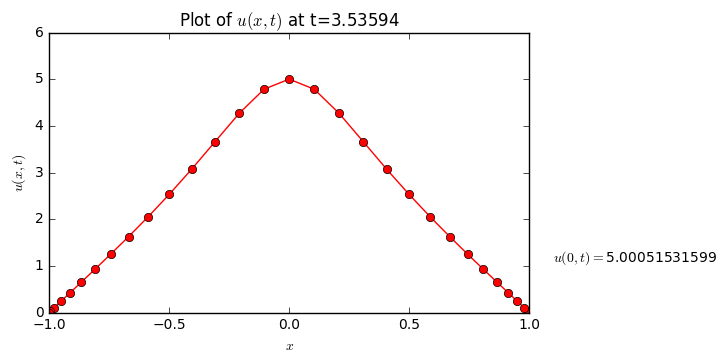

In [83]:
interact(_plot_helper, x=fixed(x), t=fixed(t), u=fixed(U), index=(0, len(t)-1))

***
***
## Part 3

__Note:__ This corresponds to exercise 10.7 from _Spectral Methods in Matlab, Trefethen._

In [3]:
# number of grid points
N = 30

# differentiation matrix and initial data
D,x = cheb(N); D2 = np.dot(D,D); D3 = np.dot(D, D2); D4 = np.dot(D, D3)

# linear map from [-20,20] to [-1,1]
alpha = 40./2
beta = 0.

# initial condition
u0 = np.exp(-x**2)

# ode solver parameters
dt = 0.00001
tmax = 5.
n_iter = int(round(tmax/dt))
t = np.linspace(0., tmax, n_iter+1)

# solution array
U = np.empty((n_iter+1, len(u0)))
U[0] = u0

def Ut(u):
    """
    It takes the values of u(x,t) at a given time t,
    and computes the temporal derivatives
    """
    return (2./alpha)*u*np.dot(D,u) + (1./alpha**2)*np.dot(D2, u) + (1./alpha**4)*np.dot(D4, u)  

# Ode solver to use
method = 'rk4'

if method=='euler':
    # Euler method
    for i in range(1, n_iter+1):
        U[i] = U[i-1] + dt * Ut(U[i-1])
        # enforcing periodic boundary conditions
        U[i,0] = U[i,-1]

elif method=='rk4':
    # RK4 method
    for i in range(1, n_iter+1):
        k1 = Ut( U[i-1] )
        k2 = Ut( U[i-1] + (dt/2.)*k1 )
        k3 = Ut( U[i-1] + (dt/2.)*k2 )
        k4 = Ut( U[i-1] + dt*k3)
        U[i] = U[i-1] + (dt/6.)*(k1 + 2*k2 + 2*k3 + k4)
        # enforcing periodic boundary conditions
        U[i,0] = U[i,-1]

/home/martin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: overflow encountered in multiply


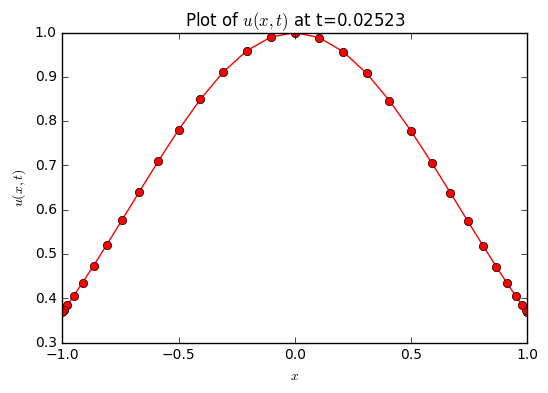

In [5]:
interact(plot_helper, x=fixed(x), t=fixed(t), u=fixed(U), index=(0, len(t)))

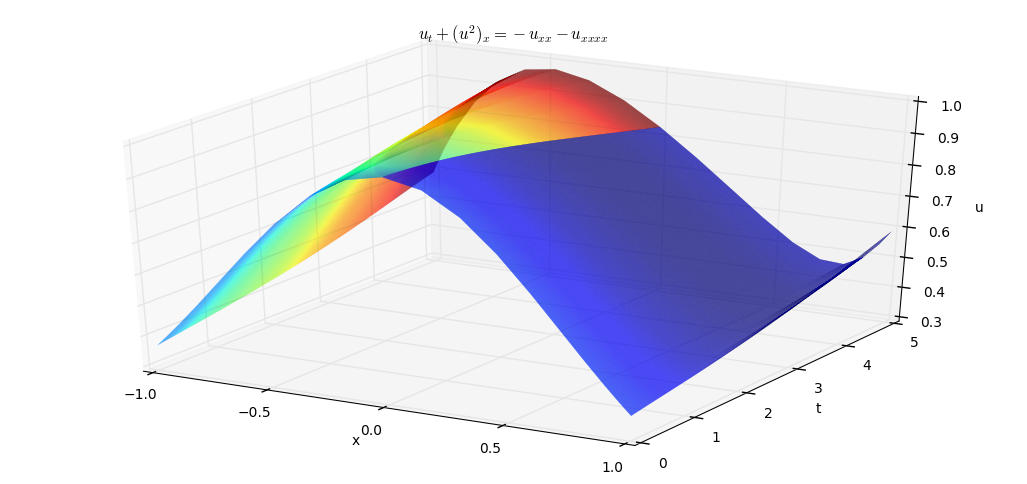

In [9]:
X,T = np.meshgrid(x, t, sparse=True)
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U, linewidth=0.0, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('$u_t + (u^2)_{x} = - u_{xx} - u_{xxxx}$')
plt.show()